In [1]:
import os
import csv
import networkx as nx
import pandas as pd
from random import shuffle

from IPython.display import display, SVG

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw

from dataset import get_dataset, preprocess
from predict_logp.predict_logp import *
from utils.graph_utils import *

In [2]:
zinc_plogp_data = pd.read_csv("gcpn/gym-molecule/gym_molecule/dataset/zinc_plogp_sorted.csv", header = None, \
                             names = ['plogp', "SMILES"])
zinc_plogp_data.head()

,plogp,SMILES
0,4.519903,COC1=CC=C(C2=CC(C3=CC=CC=C3)=CC(C3=CC=C(Br)C=C...
1,4.297502,COC1=CC=C(C2=CC(C3=CC=CC=C3)=CC(C3=CC=C(I)C=C3...
2,4.232042,FC(F)(F)C1=CC=CC(NC2=[N+](CCC3=CC=CC=C3)C(C3=C...
3,4.218235,CCCCCCC1=CC(C2=CC=CC=C2)=[O+]C(C2=CC=CC=C2)=C1
4,4.167269,COC1=CC=C(NC(=O)C2=CC=C(NC(=S)NC3=CC=C(Cl)C=C3...


In [3]:
plogp_list = zinc_plogp_data.plogp.values.tolist()
smiles_list = zinc_plogp_data.SMILES.values.tolist()

In [4]:
assert len(plogp_list)==len(smiles_list)

In [5]:
train_data = MolData(plogp_list, smiles_list)

In [6]:
train_data.__getitem__(2)

(Data(edge_attr=[34], edge_index=[2, 34], x=[31, 122]),
 tensor([4.2320]),
 Data(edge_index=[2, 961]))

In [33]:
mol = Chem.MolFromSmiles(smiles_list[2])
g = graph_utils.mol_to_pyg_graph(mol)

In [38]:
_=np.random.permutation(len(mol.GetBonds()))

In [71]:
g['edge_attr'][_][20:].float().reshape([1,14])

tensor([[1.5000, 1.5000, 1.0000, 1.0000, 1.5000, 1.5000, 1.0000, 1.5000, 1.5000,
         1.0000, 1.5000, 1.5000, 1.0000, 1.5000]])

In [70]:
print(g['edge_attr'][_][20:].float().reshape([1,14]).shape, g['edge_index'][:,_][:,20:].float().shape)

torch.Size([1, 14]) torch.Size([2, 14])


In [75]:
torch.cat((g['edge_index'][:,_][:,20:].float(), g['edge_attr'][_][20:].reshape([1,-1])), 0)

tensor([[26.0000,  5.0000, 13.0000,  0.0000, 17.0000, 28.0000, 20.0000, 22.0000,
         29.0000,  1.0000, 24.0000,  8.0000,  1.0000, 19.0000],
        [27.0000,  6.0000, 14.0000,  1.0000, 18.0000, 29.0000, 21.0000, 23.0000,
         10.0000,  2.0000, 26.0000, 30.0000,  4.0000, 14.0000],
        [ 1.5000,  1.5000,  1.0000,  1.0000,  1.5000,  1.5000,  1.0000,  1.5000,
          1.5000,  1.0000,  1.5000,  1.5000,  1.0000,  1.5000]])

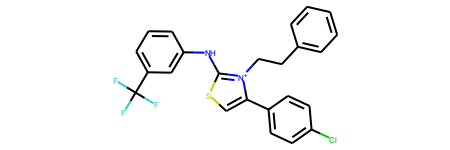

In [8]:
mol

In [9]:
nodes = []
for atom in mol.GetAtoms():
    #print(atom.GetImplicitValence())
    nodes.append(atom_to_node(atom))

edges = []
for bond in mol.GetBonds():
    edges.append(bond_to_edge(bond))

In [10]:
Chem.rdchem.HybridizationType.names

{'UNSPECIFIED': rdkit.Chem.rdchem.HybridizationType.UNSPECIFIED,
 'S': rdkit.Chem.rdchem.HybridizationType.S,
 'SP': rdkit.Chem.rdchem.HybridizationType.SP,
 'SP2': rdkit.Chem.rdchem.HybridizationType.SP2,
 'SP3': rdkit.Chem.rdchem.HybridizationType.SP3,
 'SP3D': rdkit.Chem.rdchem.HybridizationType.SP3D,
 'SP3D2': rdkit.Chem.rdchem.HybridizationType.SP3D2,
 'OTHER': rdkit.Chem.rdchem.HybridizationType.OTHER}

In [23]:
keep = int(0.8*len(mol.GetBonds()))
shuff = np.random.permutation(edges)
obs = shuff[keep]
target = shuff[keep:]

array([[13. , 14. ,  1. ],
       [ 4. ,  5. ,  1.5],
       [ 7. ,  8. ,  1.5],
       [16. , 17. ,  1.5],
       [14. , 15. ,  1.5],
       [27. , 21. ,  1.5],
       [17. , 18. ,  1.5],
       [20. , 28. ,  1.5],
       [22. , 23. ,  1.5],
       [30. ,  4. ,  1.5],
       [23. , 24. ,  1.5],
       [10. , 11. ,  1.5],
       [24. , 26. ,  1.5],
       [ 9. , 10. ,  1. ],
       [28. , 29. ,  1.5],
       [ 1. ,  2. ,  1. ],
       [26. , 27. ,  1.5],
       [ 6. ,  7. ,  1.5],
       [12. , 13. ,  1. ],
       [24. , 25. ,  1. ],
       [29. , 10. ,  1.5],
       [ 1. ,  4. ,  1. ],
       [15. , 16. ,  1.5],
       [ 1. ,  3. ,  1. ],
       [ 8. , 30. ,  1.5],
       [21. , 22. ,  1.5],
       [ 8. ,  9. ,  1. ],
       [18. , 19. ,  1.5],
       [ 5. ,  6. ,  1.5],
       [20. , 21. ,  1. ],
       [11. , 20. ,  1.5],
       [ 0. ,  1. ,  1. ],
       [11. , 12. ,  1. ],
       [19. , 14. ,  1.5]])

In [13]:
edges

[[0, 1, 1.0],
 [1, 2, 1.0],
 [1, 3, 1.0],
 [1, 4, 1.0],
 [4, 5, 1.5],
 [5, 6, 1.5],
 [6, 7, 1.5],
 [7, 8, 1.5],
 [8, 9, 1.0],
 [9, 10, 1.0],
 [10, 11, 1.5],
 [11, 12, 1.0],
 [12, 13, 1.0],
 [13, 14, 1.0],
 [14, 15, 1.5],
 [15, 16, 1.5],
 [16, 17, 1.5],
 [17, 18, 1.5],
 [18, 19, 1.5],
 [11, 20, 1.5],
 [20, 21, 1.0],
 [21, 22, 1.5],
 [22, 23, 1.5],
 [23, 24, 1.5],
 [24, 25, 1.0],
 [24, 26, 1.5],
 [26, 27, 1.5],
 [20, 28, 1.5],
 [28, 29, 1.5],
 [8, 30, 1.5],
 [30, 4, 1.5],
 [29, 10, 1.5],
 [19, 14, 1.5],
 [27, 21, 1.5]]

In [14]:
nodes = np.array(nodes, dtype = float)[:,1:]

In [15]:
nodes

array([[ 9.,  0.,  0.,  0.,  1.],
       [ 6.,  0.,  0.,  0.,  4.],
       [ 9.,  0.,  0.,  0.,  1.],
       [ 9.,  0.,  0.,  0.,  1.],
       [ 6.,  0.,  0.,  1.,  3.],
       [ 6.,  0.,  1.,  1.,  2.],
       [ 6.,  0.,  1.,  1.,  2.],
       [ 6.,  0.,  1.,  1.,  2.],
       [ 6.,  0.,  0.,  1.,  3.],
       [ 7.,  0.,  1.,  0.,  2.],
       [ 6.,  0.,  0.,  1.,  3.],
       [ 7.,  1.,  0.,  1.,  3.],
       [ 6.,  0.,  2.,  0.,  2.],
       [ 6.,  0.,  2.,  0.,  2.],
       [ 6.,  0.,  0.,  1.,  3.],
       [ 6.,  0.,  1.,  1.,  2.],
       [ 6.,  0.,  1.,  1.,  2.],
       [ 6.,  0.,  1.,  1.,  2.],
       [ 6.,  0.,  1.,  1.,  2.],
       [ 6.,  0.,  1.,  1.,  2.],
       [ 6.,  0.,  0.,  1.,  3.],
       [ 6.,  0.,  0.,  1.,  3.],
       [ 6.,  0.,  1.,  1.,  2.],
       [ 6.,  0.,  1.,  1.,  2.],
       [ 6.,  0.,  0.,  1.,  3.],
       [17.,  0.,  0.,  0.,  1.],
       [ 6.,  0.,  1.,  1.,  2.],
       [ 6.,  0.,  1.,  1.,  2.],
       [ 6.,  0.,  1.,  1.,  2.],
       [16.,  

In [16]:
print(len(mol.GetAtoms()), len(mol.GetBonds()))

31 34


In [17]:
nodes[:,1:].shape

(31, 4)

In [18]:
g.edge_index

tensor([[ 0,  1,  1,  1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 11, 20, 21, 22, 23, 24, 24, 26, 20, 28,  8, 30, 29, 19, 27],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,  4, 10, 14, 21]])

In [ ]:
#Should I only randomly remove edges that chemically make sense?